# Stock Price Prediction (Colab-Ready, LSTM)

This notebook provides a robust end-to-end workflow for stock price prediction using an LSTM model:
- Data fetch via `yfinance`
- Cleaning & feature engineering
- Scaling & sequence creation
- Model training with callbacks (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
- Evaluation (MAE, RMSE, MAPE)
- Visualizations of predictions vs. actuals
- Simple multi-step forecasting (recursive)

In [1]:
# If running on Colab, uncomment the next cell to install dependencies.
# !pip install -q yfinance pandas numpy scikit-learn tensorflow matplotlib

In [2]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, List

import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras import layers, callbacks, models

plt.rcParams["figure.figsize"] = (12, 5)
pd.set_option("display.width", 180)
pd.set_option("display.max_columns", 50)
print("TensorFlow:", tf.__version__)

TensorFlow: 2.19.0


In [3]:
# ==== Configuration ====
TICKER = "AAPL"          # change this to whatever ticker you want
START_DATE = "2015-01-01"
END_DATE   = None         # None = today
PRICE_COL  = "Close"      # target column for prediction
SEQ_LEN    = 60           # lookback window
TEST_SIZE  = 0.2          # 20% of data for testing
BATCH_SIZE = 64
EPOCHS     = 25
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [4]:
# ==== Fetch historical data ====
df = yf.download(TICKER, start=START_DATE, end=END_DATE, auto_adjust=True, progress=False)
if df.empty:
    raise ValueError(f"No data downloaded for {TICKER}. Check the symbol or date range.")

display(df.tail())
print("Data shape:", df.shape)

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-08-25,227.160004,229.300003,226.229996,226.479996,30983100
2025-08-26,229.309998,229.490005,224.690002,226.869995,54575100
2025-08-27,230.490005,230.899994,228.259995,228.610001,31259500
2025-08-28,232.559998,233.410004,229.339996,230.820007,38074700
2025-08-29,232.139999,233.380005,231.369995,232.509995,39389400


Data shape: (2681, 5)


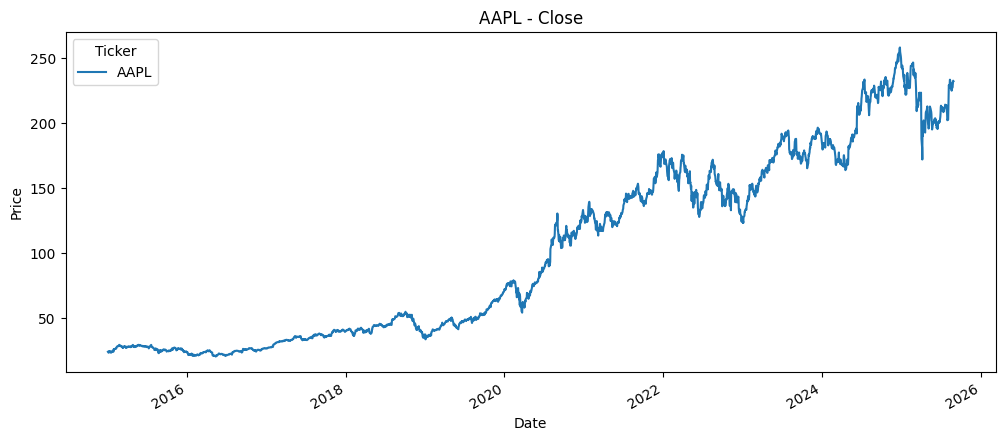

In [5]:
# ==== Quick EDA: plot closing price ====
df[PRICE_COL].plot(title=f"{TICKER} - {PRICE_COL}")
plt.xlabel("Date"); plt.ylabel("Price")
plt.show()

In [6]:
# ==== Feature selection ====
# You can include additional features for the model (e.g., Open, High, Low, Volume).
# For simplicity, we'll start with using only the target column.
features = [PRICE_COL]
data = df[features].copy()

# Scale features to [0, 1]
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.values)
print("Scaled shape:", data_scaled.shape)

Scaled shape: (2681, 1)


In [7]:
def create_sequences(arr: np.ndarray, seq_len: int) -> Tuple[np.ndarray, np.ndarray]:
    X, y = [], []
    for i in range(seq_len, len(arr)):
        X.append(arr[i - seq_len:i])
        y.append(arr[i, 0])  # target is first column (PRICE_COL)
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return X, y

X_all, y_all = create_sequences(data_scaled, SEQ_LEN)
print("X_all:", X_all.shape, "y_all:", y_all.shape)

X_all: (2621, 60, 1) y_all: (2621,)


In [8]:
# Time-based split
split_idx = int((1.0 - TEST_SIZE) * len(X_all))
X_train, y_train = X_all[:split_idx], y_all[:split_idx]
X_test, y_test   = X_all[split_idx:], y_all[split_idx:]

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (2096, 60, 1) (2096,)
Test : (525, 60, 1) (525,)


In [9]:
def build_lstm(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(64),
        layers.Dropout(0.2),
        layers.Dense(32, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

model = build_lstm((SEQ_LEN, len(features)))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,033 (203.25 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 0.0195 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0013 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 8.9233e-04 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 7.6275e-04 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 8.0594e-04 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 7.5492e-04 - val_loss: 8.4013e-04 - learning_rate: 0.0010
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 6.7476e-04 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 6.9926e-04 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 9/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 7.2368e-04 - val_loss: 0.0028 - learning

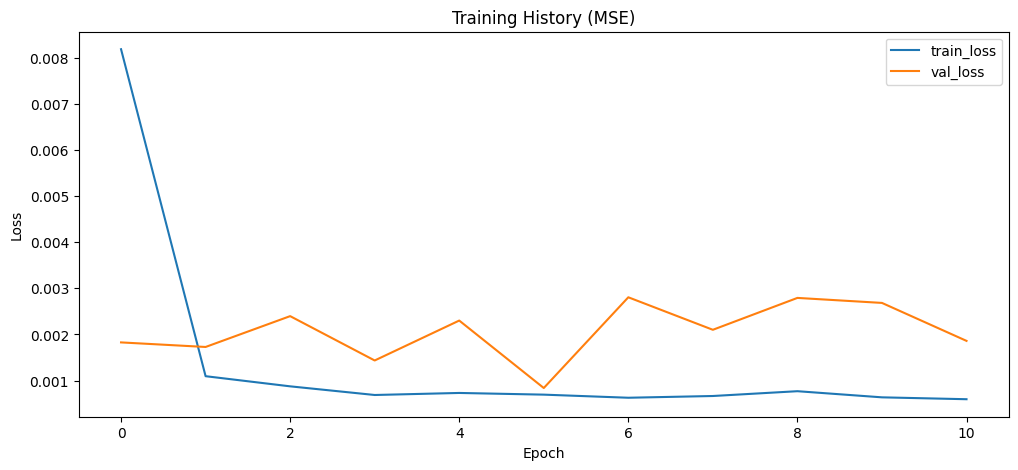

In [10]:
es = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5)
ckpt_path = "best_lstm.keras"
mc = callbacks.ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True, verbose=0)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es, rlr, mc],
    verbose=1
)

plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Training History (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [11]:
def inverse_scale(y_scaled: np.ndarray) -> np.ndarray:
    # y_scaled is (n,) for target. Need to map back through the scaler that was fit on full feature array.
    # Construct array with same number of features, fill target in first column.
    n = y_scaled.shape[0]
    tmp = np.zeros((n, len(features)))
    tmp[:, 0] = y_scaled
    inv = scaler.inverse_transform(tmp)[:, 0]
    return inv

# Predict
y_pred_test_scaled = model.predict(X_test).reshape(-1)
y_pred_train_scaled = model.predict(X_train).reshape(-1)

# Inverse transform to price units
y_test_inv = inverse_scale(y_test)
y_train_inv = inverse_scale(y_train)
y_pred_test_inv = inverse_scale(y_pred_test_scaled)
y_pred_train_inv = inverse_scale(y_pred_train_scaled)

# Metrics
def rmse(a, b):
    return math.sqrt(mean_squared_error(a, b))

def mape(a, b):
    return np.mean(np.abs((a - b) / np.maximum(1e-8, a))) * 100.0

metrics = {
    "train_MAE": float(mean_absolute_error(y_train_inv, y_pred_train_inv)),
    "train_RMSE": float(rmse(y_train_inv, y_pred_train_inv)),
    "train_MAPE_%": float(mape(y_train_inv, y_pred_train_inv)),
    "test_MAE": float(mean_absolute_error(y_test_inv, y_pred_test_inv)),
    "test_RMSE": float(rmse(y_test_inv, y_pred_test_inv)),
    "test_MAPE_%": float(mape(y_test_inv, y_pred_test_inv)),
}
pd.DataFrame([metrics])

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


,train_MAE,train_RMSE,train_MAPE_%,test_MAE,test_RMSE,test_MAPE_%
0,2.872309,4.256573,3.59882,9.125084,11.297458,4.307476


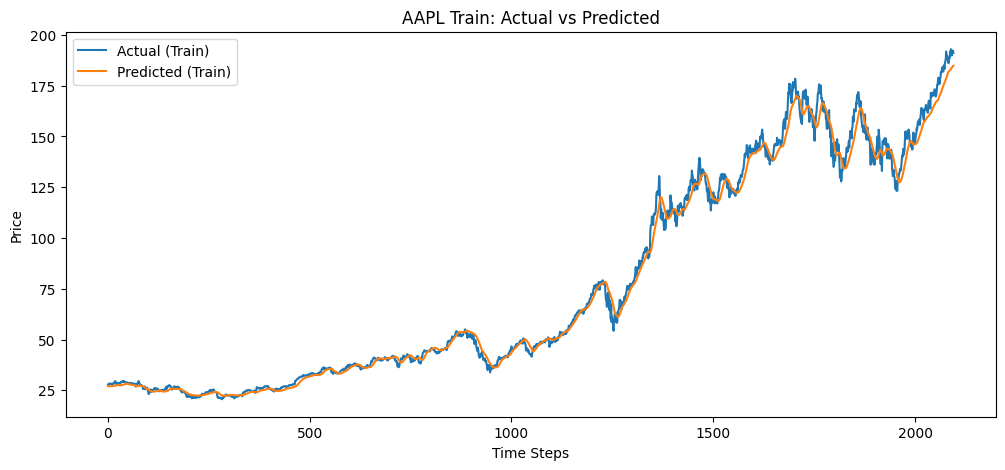

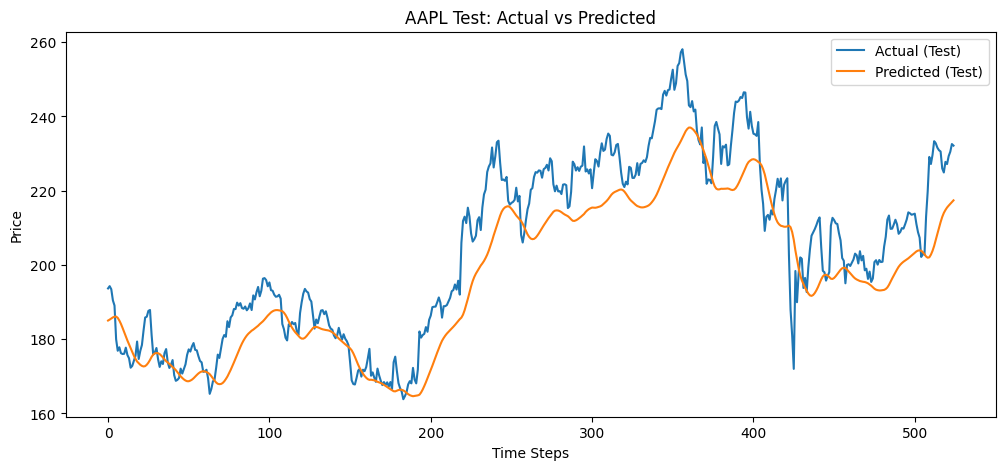

In [12]:
# Plot Train Predictions
plt.plot(y_train_inv, label="Actual (Train)")
plt.plot(y_pred_train_inv, label="Predicted (Train)")
plt.title(f"{TICKER} Train: Actual vs Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.show()

# Plot Test Predictions
plt.plot(y_test_inv, label="Actual (Test)")
plt.plot(y_pred_test_inv, label="Predicted (Test)")
plt.title(f"{TICKER} Test: Actual vs Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.show()

In [13]:
def forecast_next_days(last_seq: np.ndarray, steps: int) -> np.ndarray:
    # last_seq: shape (SEQ_LEN, num_features) scaled
    # returns: array of scaled predictions of length `steps`
    seq = last_seq.copy()
    preds = []
    for _ in range(steps):
        pred = model.predict(seq[np.newaxis, ...], verbose=0)[0, 0]
        preds.append(pred)
        # shift sequence window and append new prediction in target column
        next_step = seq[1:].copy()
        next_row = seq[-1:].copy()
        next_row[0, 0] = pred  # update target
        seq = np.vstack([next_step, next_row])
    return np.array(preds, dtype=np.float32)

# Prepare last window from full data
last_window = X_all[-1]
future_days = 5  # change as needed
future_scaled = forecast_next_days(last_window, steps=future_days)

# Inverse-scale forecast
future_pred = inverse_scale(future_scaled)
pd.DataFrame({"day_ahead": np.arange(1, future_days + 1), "forecast_price": future_pred})

,day_ahead,forecast_price
0,1,217.395266
1,2,217.393936
2,3,217.070723
3,4,216.521980
4,5,215.817237
